In [15]:
#!pip install EnsemblePursuit
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler

In [4]:
data_path='/media/maria/DATA1/Documents/data_for_suite2p/TX39/'
dt=1
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
print(S.shape)
#Uncomment to compute U and V
#ep=EnsemblePursuit(n_components=50,lam=0.01,n_kmeans=50)
#model=ep.fit(S.T[:10000,:])
#V=model.components_
#U=model.weights
#np.save('U.npy',U)

Shape of the data matrix, neurons by timepoints: (18795, 30766)
(18795, 30560)


In [5]:
U=np.load('U.npy')

In [21]:
stim_ens_ind=np.nonzero(U[:,13])[0][0]
print(S.max())
stim_inp=S[stim_ens_ind]
print(stim_inp.shape)
scaler=MinMaxScaler()
stim_inp=scaler.fit_transform(stim_inp.reshape(-1,1))

5689.182
(30560,)


[[0.01597081]
 [0.34601653]
 [0.34481776]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


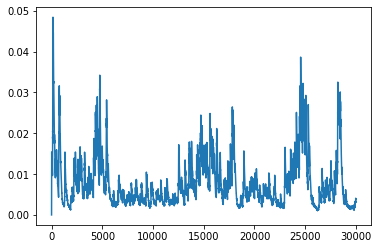

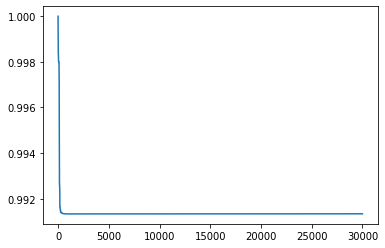

In [90]:
def gain_function(x):
        #x=np.array(x)
        #x[x<0]= 0.5*np.tanh(x[x<0]/0.5)
        if x<0:
            return 0.5*np.tanh(x/0.5)
        else:
            return (1-0.5)*np.tanh(x/(1.0-0.5))
        #x[x>=0]=(1.0-0.5)*np.tanh(x[x>=0]/(1.0-0.5))
        return x
    
def update_weights(pre_syn_activity_pattern,post_syn_activity_pattern,W,theta_BCM):
    alpha = 0.0001
    #print('syn',pre_syn_activity_pattern.reshape(9479,1)@post_syn_activity_pattern.reshape(1,2))
    W+= alpha*pre_syn_activity_pattern*post_syn_activity_pattern*(post_syn_activity_pattern-theta_BCM)
    W=W.item()
    return W
def update_BCM_threshold(theta_BCM,activity_pattern):
    theta_BCM_dt = .01
    BCM_target = 2.0
    theta_BCM += theta_BCM_dt*((activity_pattern/BCM_target)*activity_pattern - theta_BCM)
    return theta_BCM

activity_patterns=stim_inp
print(activity_patterns)
#plt.plot(activity_patterns)
weight=1.0

#print(weights.shape)
theta_BCM = 1000.0
rate=[0]
h=0.01
weights_lst=[]
for t in range(0,30000):
    #print(activity_patterns[t])
    inpt=weight*activity_patterns[t]
    #print(inpt)
    dxdt=(-rate[-1]+gain_function(inpt)).item()
    rate.append(rate[-1]+h*dxdt)
    weight=update_weights(activity_patterns.flatten()[t],rate[-1],weight,theta_BCM)
    weights_lst.append(weight)
    theta_BCM=update_BCM_threshold(theta_BCM,rate[-1])
#print(rate)
plt.plot(rate)
#plt.plot(weight)
plt.show()
plt.plot(weights_lst)
plt.show()

In [89]:
print(len(rate[1:]))
print(stim_inp.shape)
print(np.corrcoef(rate[1:],stim_inp[:30000].flatten()))


30000
(30560, 1)
[[1.         0.19003032]
 [0.19003032 1.        ]]


In [95]:
v_lst=np.array(rate)
#v_lst=np.array(zscore(v_lst))
mov=np.load(data_path+'mov.npy')
mov = mov[:, :, ivalid]
ly, lx, nstim = mov.shape
#print(nstim)
NT = v_lst.shape[0]
NN=1
mov=mov[:,:,:NT]
print(NT)
itrain,itest=train_test_split(NT)

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # subtract the background
X = np.abs(X) # does not matter if a pixel is black (0) or white (1)
X = zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = 0.1
#ncomps = Sp.shape[0]
B0 = np.linalg.solve((X[:,itrain] @ X[:,itrain].T + lam * np.eye(npix)),  (X[:,itrain] @ v_lst[itrain].T)) # get the receptive fields for each neuron

B0 = np.reshape(B0, (ly, lx, 1))
B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a littleb

30001


NameError: name 'train_test_split' is not defined